<a href="https://colab.research.google.com/github/katenevm/product_engagementa_analysis/blob/main/Web_Traffic_and_Product_Engagement_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
1. [Dataset description](#dataset-description)
    - [Short Overview](##short-overview)
    - [Sales by locations](##sales-by-locations**)
    - [Sales by categories](##sales-by-categories)
    - [Sales by devices](##sales-by-devices)
    - [Verified and unsubscribed](##verified-and-unsubscribed)
    - [Orders out of registered and not registered users](##orders-out-of-registered-and-not-registered-users)
2. [Analysis of sales dynamics](#analysis-of-sales-dynamics)
3. [Summary Tables](#summary-tables)
4. [Statistical analysis of relationships](#statistical-analysis-of-relationships)
5.[Statistical analysis of differences between groups](#statistical-analysis-of-differences-between-groups)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from google.colab import drive
from google.cloud import bigquery
from statsmodels.stats.proportion import proportions_ztest

import statistics as s
from scipy import stats
from scipy.stats import shapiro, ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import normaltest, shapiro
from scipy.stats import f_oneway
import statsmodels.api as sm
from scipy.stats import kruskal
from scipy.stats import wilcoxon



In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
# Create a BigQuery client
client = bigquery.Client(project="data-analytics-mate")

In [5]:
query = """
SELECT
s.date as order_date,
sp.ga_session_id,
sp.continent,
sp.country,
sp.device,
sp.browser,
sp.mobile_model_name,
sp.operating_system,
sp.language,
sp.name as trafic_info,
sp.channel,
acs.account_id,
a.is_verified,
a.is_unsubscribed,
p.category,
p.price,
p.short_description
FROM `DA.session_params` as sp
LEFT JOIN `DA.session` as s
ON sp.ga_session_id = s.ga_session_id
LEFT JOIN `DA.account_session` as acs
ON sp.ga_session_id = acs.ga_session_id
LEFT JOIN `DA.account`as a
ON acs.account_id = a.id
LEFT JOIN `DA.order` as o
ON sp.ga_session_id = o.ga_session_id
LEFT JOIN `DA.product` as p
ON o.item_id = p.item_id
"""

df = client.query(query)
df = df.to_dataframe()
df

,order_date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,trafic_info,channel,account_id,is_verified,is_unsubscribed,category,price,short_description
0,2021-01-19,7268004754,(not set),(not set),desktop,Chrome,Chrome,Web,en-gb,(direct),Direct,<NA>,<NA>,<NA>,None,NaN,None
1,2021-01-06,8321293308,(not set),(not set),desktop,Chrome,Chrome,Web,None,(direct),Direct,<NA>,<NA>,<NA>,None,NaN,None
2,2020-11-05,4392362373,(not set),(not set),desktop,Chrome,Chrome,Web,None,(organic),Organic Search,<NA>,<NA>,<NA>,None,NaN,None
3,2020-12-09,140108698,(not set),(not set),desktop,Chrome,Safari,Web,en-us,(direct),Direct,<NA>,<NA>,<NA>,None,NaN,None
4,2020-11-10,8351127264,(not set),(not set),mobile,Safari,iPhone,Web,en-us,(organic),Organic Search,<NA>,<NA>,<NA>,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349540,2020-11-25,353517,Americas,Canada,desktop,Chrome,Safari,Macintosh,None,(data deleted),Undefined,<NA>,<NA>,<NA>,None,NaN,None
349541,2020-11-09,2536581233,Americas,United States,desktop,Chrome,Safari,Macintosh,None,(data deleted),Undefined,<NA>,<NA>,<NA>,None,NaN,None
349542,2021-01-02,2149190429,Americas,Canada,desktop,Chrome,Safari,Macintosh,de,(data deleted),Undefined,<NA>,<NA>,<NA>,None,NaN,None
349543,2021-01-08,6004211753,Americas,United States,desktop,Chrome,Safari,Macintosh,None,(data deleted),Undefined,<NA>,<NA>,<NA>,None,NaN,None


# **DATASET DESCRIPTION**

In [6]:
df.info()
print('')
unique_sessions = df['ga_session_id'].nunique()
print(f'Unique sessions number: {unique_sessions}')
print('')
max_time = df['order_date'].max()
min_time = df['order_date'].min()
print(f'We are researching data starting from:{min_time} till:{max_time}')

# number of missing values in each column
missing_values = df.isnull().sum()
print('')
print('Number of missing values in each column:')
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   trafic_info        349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  category           33538 non-null   object 
 15  price              33538 non-null   float64
 16  sh

In [7]:
missing_values_lang_percent = df['language'].isnull().sum() / df.shape[0]*100
missing_accounts_percent = df['account_id'].isnull().sum() / df.shape[0]*100
missing_order = df['category'].isnull().sum() / df.shape[0]*100

print(f'There are {missing_values_lang_percent:.2f}% missing values in the language column')
print(f'Out of all the existing sessions {missing_accounts_percent:.2f}% of users didnt make an account')
print(f'Out of all the existing sessions {missing_order:.2f}% of users didnt make an order')

There are 32.69% missing values in the language column
Out of all the existing sessions 92.01% of users didnt make an account
Out of all the existing sessions 90.41% of users didnt make an order


## **SHORT OVERVIEW**
- Total number of columns - (total 17 columns)
- Number of numeric columns (and which ones) - 5 (ga_session_id, account_id, is_verified, is_unsubscribed, price)
- Number of categorical columns (and which ones) - 10 (continent, country, device, browser, mobile_model_name, operating_system, language, trafic_info, channel, category)
- Number of datetime columns - 1 (order_date)
- Number of unique sessions - 349545
Time period under consideration (from… to…) - We are researching data starting from: 2020-11-01 till: 2021-01-31
- Are there missing values?
- In which columns are most of the missing values, and what is the reason?
  - There are 114266 missing values in the language column (32.69%), probably because people rerely set the prefered language
  - There are 321600 missing values in the account_id, is_verified, is_unsubscribed, because 321600 number of users (92.01%) did the session, but didn't made their account, so all the information related to their accounts are missing
  - There are 316007 missing values in the category, price and short description, because 316007 users (90.41%) didn't make an order, so all information related to the product is missing


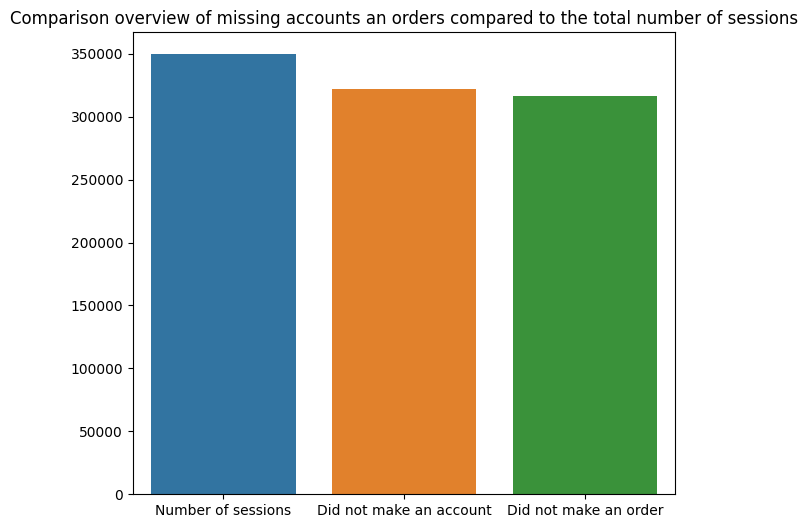

In [8]:
missing_accounts = df['account_id'].isnull().sum()
missing_orders = df['category'].isnull().sum()

df_overview = {
    'Number of sessions': [unique_sessions],
    'Did not make an account': [missing_accounts],
    'Did not make an order': [missing_orders]
}

df_overview = pd.DataFrame(df_overview)

plt.figure(figsize=(7, 6))
sns.barplot(data=df_overview)
plt.title('Comparison overview of missing accounts an orders compared to the total number of sessions')
plt.show()

From this point it can be concluded that
- more than 92% of users use the web without the registration



## **Sales by locations**

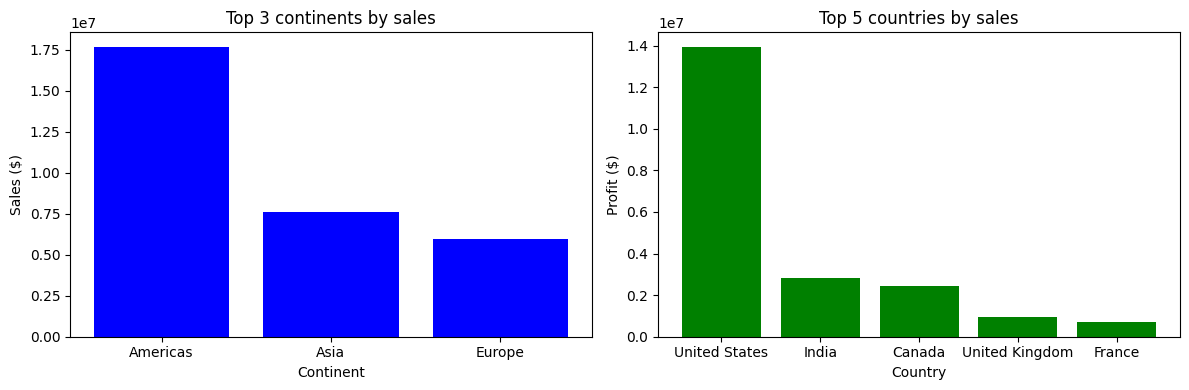

In [9]:
continents = df.groupby('continent')['price'].sum().sort_values(ascending=False).head(3)
countries = df.groupby('country')['price'].sum().sort_values(ascending=False).head(5)


fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# First subplot
ax[0].bar(continents.index, continents.values, color="blue")
ax[0].set_title("Top 3 continents by sales")
ax[0].set_xlabel("Continent")
ax[0].set_ylabel("Sales ($)")

# Second subplot
ax[1].bar(countries.index, countries.values,  color="green")
ax[1].set_title("Top 5 countries by sales")
ax[1].set_xlabel("Country")
ax[1].set_ylabel("Profit ($)")

plt.tight_layout()
plt.show()


Highest sales are in the America

## Sales by categories

In [10]:
top_categories = df.groupby('category')['price'].sum().head(10)
top_usa_categories = df[(df['country'] == 'United States') & (df['category'].notnull())]
top_usa_categories = top_usa_categories.groupby('category')['price'].sum().head(10)

<ipython-input-11-fd3cca093640>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')  # Rotate the labels
<ipython-input-11-fd3cca093640>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')  # Rotate the labels


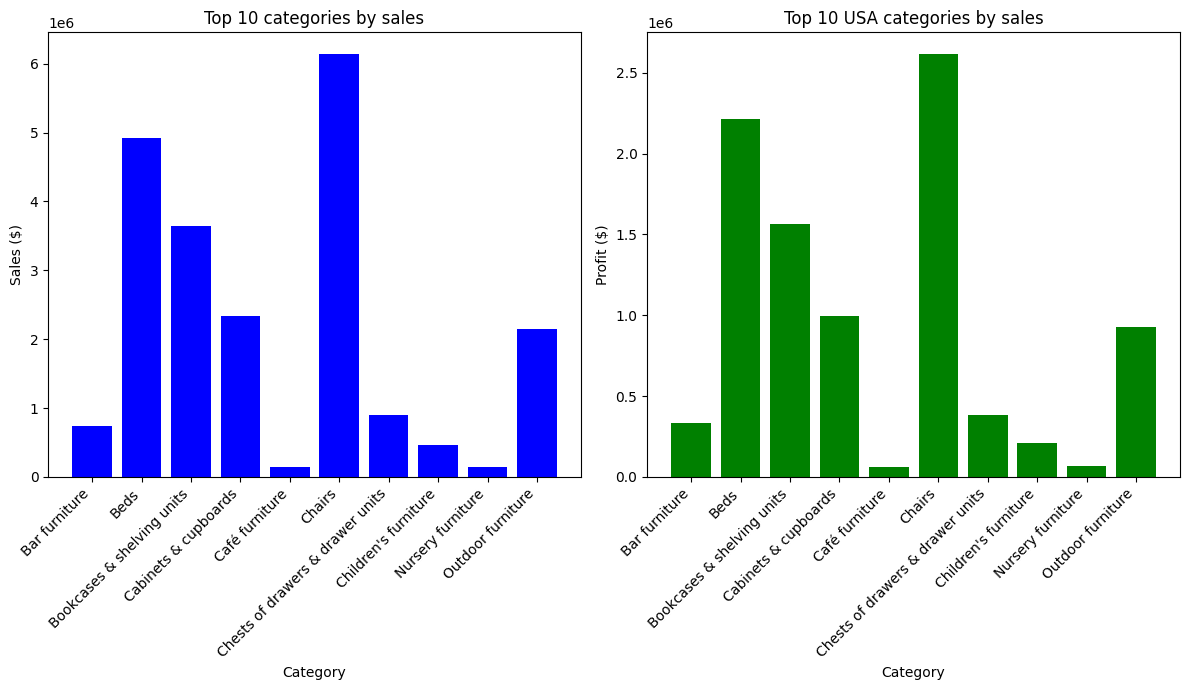

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

# First subplot
ax[0].bar(top_categories.index, top_categories.values, color="blue")
ax[0].set_title("Top 10 categories by sales")
x_tickers = ax[0].get_xticks()  # Get the tick positions
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')  # Rotate the labels
ax[0].set_xlabel("Category")
ax[0].set_ylabel("Sales ($)")

# Second subplot
ax[1].bar(top_usa_categories.index, top_usa_categories.values,  color="green")
ax[1].set_title("Top 10 USA categories by sales")
ax[1].set_xlabel("Category")
x_tickers = ax[1].get_xticks()  # Get the tick positions
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')  # Rotate the labels
ax[1].set_ylabel("Profit ($)")

plt.tight_layout()
plt.show()

**Conclusion**

The proportions of the most popular products don't differ between the largest buyer country and the overall global distribution

## **Sales by devices**

In [12]:
# Percentage of sales by device
device_sales = df.groupby('device')['price'].sum()
device_sales_percent = (device_sales / device_sales.sum()) * 100
device_sales_percent

# Percentage of sales by channel
channel_sales = df.groupby('channel')['price'].sum()
channel_sales_percent = (channel_sales / channel_sales.sum()) * 100

device_sales_percent

,price
device,
desktop,59.002245
mobile,38.734924
tablet,2.262831


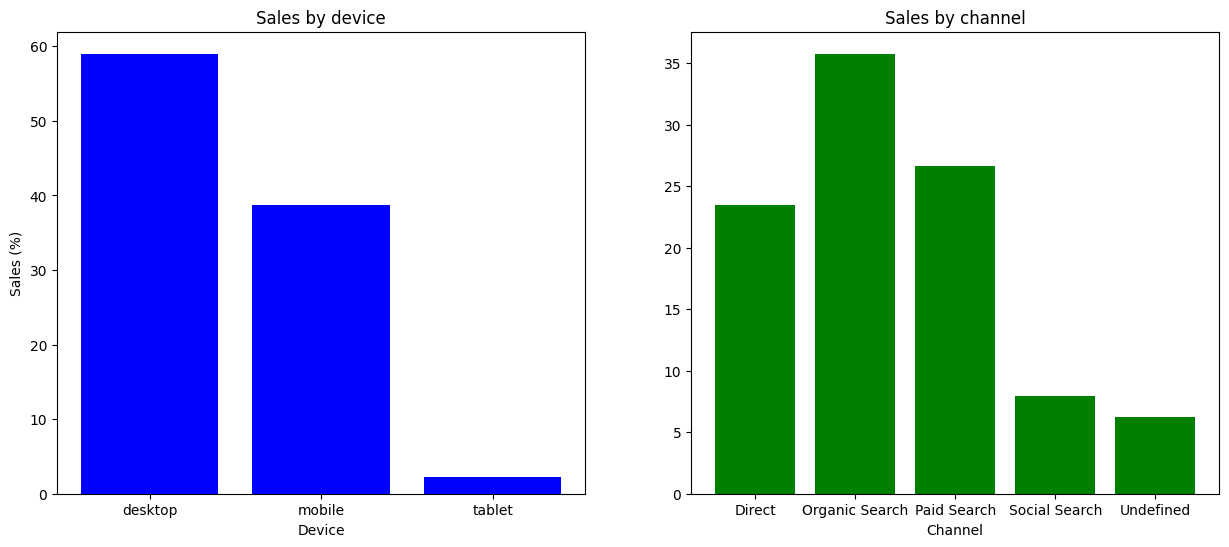

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].bar(device_sales_percent.index, device_sales_percent.values, color="blue")
ax[0].set_title("Sales by device")
ax[0].set_xlabel("Device")
ax[0].set_ylabel("Sales (%)")

ax[1].bar(channel_sales_percent.index, channel_sales_percent.values,  color="green")
ax[1].set_title("Sales by channel")
ax[1].set_xlabel("Channel")

plt.show()

## **Verified and unsubscribed**

In [14]:
# Table of registered users
registered = df[df['account_id'].notnull()]

# Percent of verified accounts and percent of accounts unsubscribed from the messages
verified_outof_registered = registered[registered['is_verified'] == 1].shape[0] / registered.shape[0] * 100
unsubscribed_outof_registered = registered[registered['is_unsubscribed'] == 1].shape[0] / registered.shape[0] * 100

print(f'Percent of verified accounts: {verified_outof_registered:.2f}%')
print(f'Percent of accounts unsubscribed from the messages: {unsubscribed_outof_registered:.2f}%')


Percent of verified accounts: 71.70%
Percent of accounts unsubscribed from the messages: 16.94%


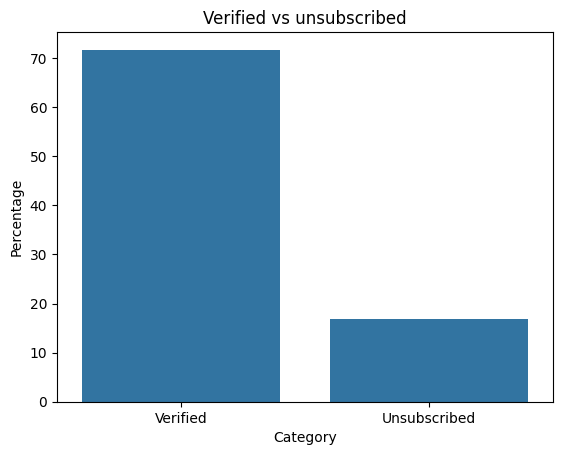

In [15]:
data = pd.DataFrame({
    'Category': ['Verified', 'Unsubscribed'],
    'Percentage': [verified_outof_registered, unsubscribed_outof_registered]
})


sns.barplot(data=data, x='Category', y='Percentage')
plt.title('Verified vs unsubscribed')
plt.show()

Subscribed users demonstrate higher loyalty, with a greater proportion verifying their accounts and remaining subscribed to the mailing list.

## **Orders out of registered and not registered users**

In [16]:
not_registered = df[df['account_id'].isnull()]

registered_made_order = registered[registered['category'].notnull()].shape[0] / registered.shape[0] * 100
not_registered_made_order = not_registered[not_registered['category'].notnull()].shape[0] / not_registered.shape[0] * 100


print(f'Percent of registered users who made an order: {registered_made_order:.2f}%')
print(f'Percent of not registered users who made an order: {not_registered_made_order:.2f}%')

Percent of registered users who made an order: 9.95%
Percent of not registered users who made an order: 9.56%


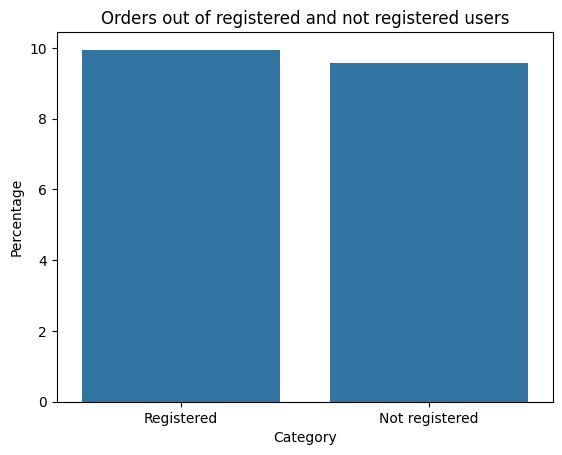

In [17]:
data = pd.DataFrame({
    'Category': ['Registered', 'Not registered'],
    'Percentage': [registered_made_order, not_registered_made_order]
})

sns.barplot(data=data, x='Category', y='Percentage')
plt.title('Orders out of registered and not registered users')
plt.show()


We can see that almost the same percent of users from both samples made an order

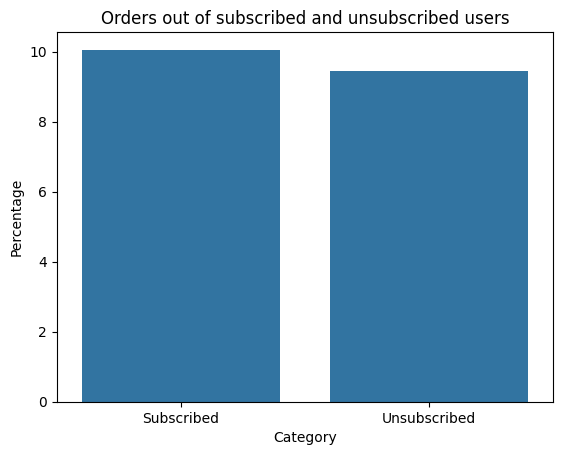

In [18]:
subscribed = df[df['is_unsubscribed']== 0]
unsubscribed = df[df['is_unsubscribed']== 1]

subscribed_made_order = subscribed[subscribed['category'].notnull()].shape[0] / subscribed.shape[0] * 100
unsubscribed_made_order = unsubscribed[unsubscribed['category'].notnull()].shape[0] / unsubscribed.shape[0] * 100

data = pd.DataFrame(
    {
        'Category': ['Subscribed', 'Unsubscribed'],
        'Percentage': [subscribed_made_order, unsubscribed_made_order]
    }
)

sns.barplot(data=data, x='Category', y='Percentage')
plt.title('Orders out of subscribed and unsubscribed users')
plt.show()

Subscribed users show a slightly higher tendency to place orders, though the difference is minimal.

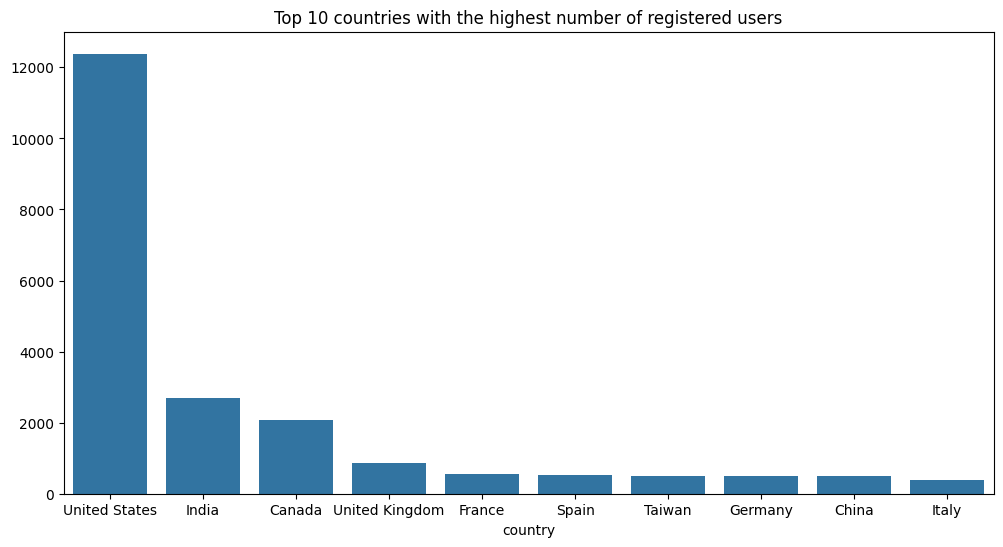

In [19]:
subscribed_by_country = registered.groupby('country')['account_id'].count().sort_values(ascending=False)
subscribed_by_country = subscribed_by_country.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x = subscribed_by_country.index, y = subscribed_by_country.values)
plt.title('Top 10 countries with the highest number of registered users')
plt.show()


The United States have the highest number of registered users.

# **Analysis of sales dynamics**

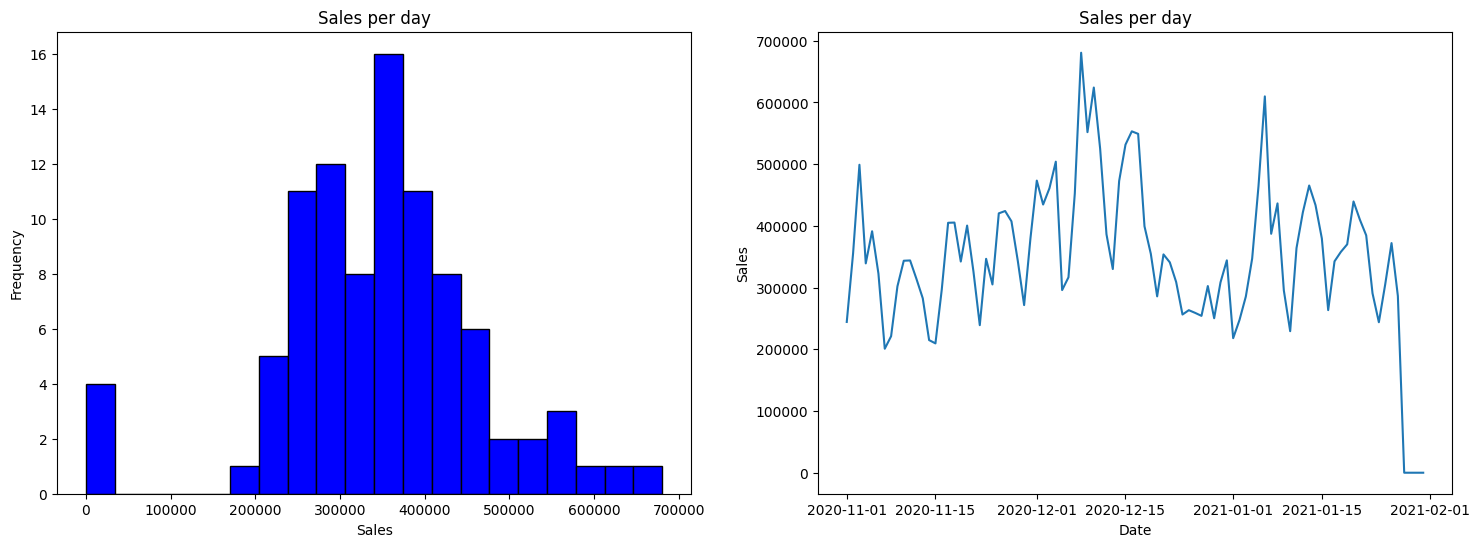

In [20]:
# histogram of sales
df['order_date'] = pd.to_datetime(df['order_date'])
sales_per_day = df.groupby('order_date')['price'].sum()
sales_per_day =pd.DataFrame(sales_per_day)
sales_per_day = sales_per_day.rename(columns={'price': 'sales'})

fig, ax = plt.subplots(1,2, figsize = (18, 6))


ax[0].hist(data = sales_per_day, x = 'sales', bins = 20, color = 'blue', edgecolor = 'black')
ax[0].set_xlabel('Sales')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Sales per day')


sales_per_day = sales_per_day.reset_index()
ax[1].plot(sales_per_day['order_date'], sales_per_day['sales'])
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Sales')
ax[1].set_title('Sales per day')


plt.show()

- The most frequent sales amount is approximately 350,000.
- The highest sales occurred in the middle of December.
- We cannot determine if sales are seasonal because the data only covers two months, which is insufficient to observe seasonal trends.

<ipython-input-21-2d286bdcfc3b>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data = sales_per_continent, x = 'order_date', y = 'price', hue = 'continent', ci=None)


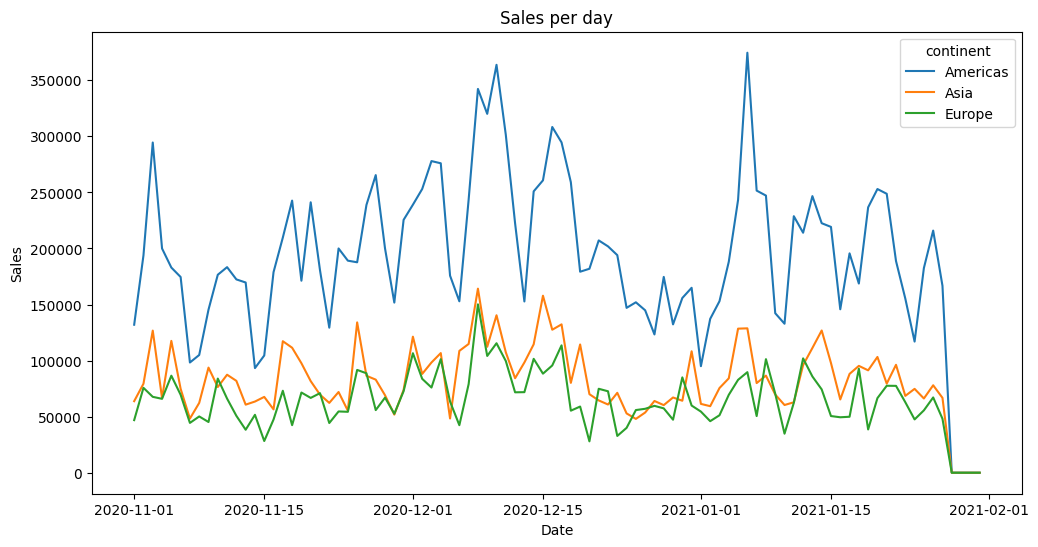

In [21]:
sales_per_continent = df[df['continent'].isin(['Europe', 'Asia', 'Americas'])]

sales_per_continent = sales_per_continent.groupby(['order_date', 'continent'])['price'].sum().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data = sales_per_continent, x = 'order_date', y = 'price', hue = 'continent', ci=None)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales per day')
plt.show()

Sales in the Americas are outperforming those in other regions.

<ipython-input-22-d7b9dfacdd82>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data = sales_per_channel, x = 'order_date', y = 'price', hue = 'channel', ci=None)


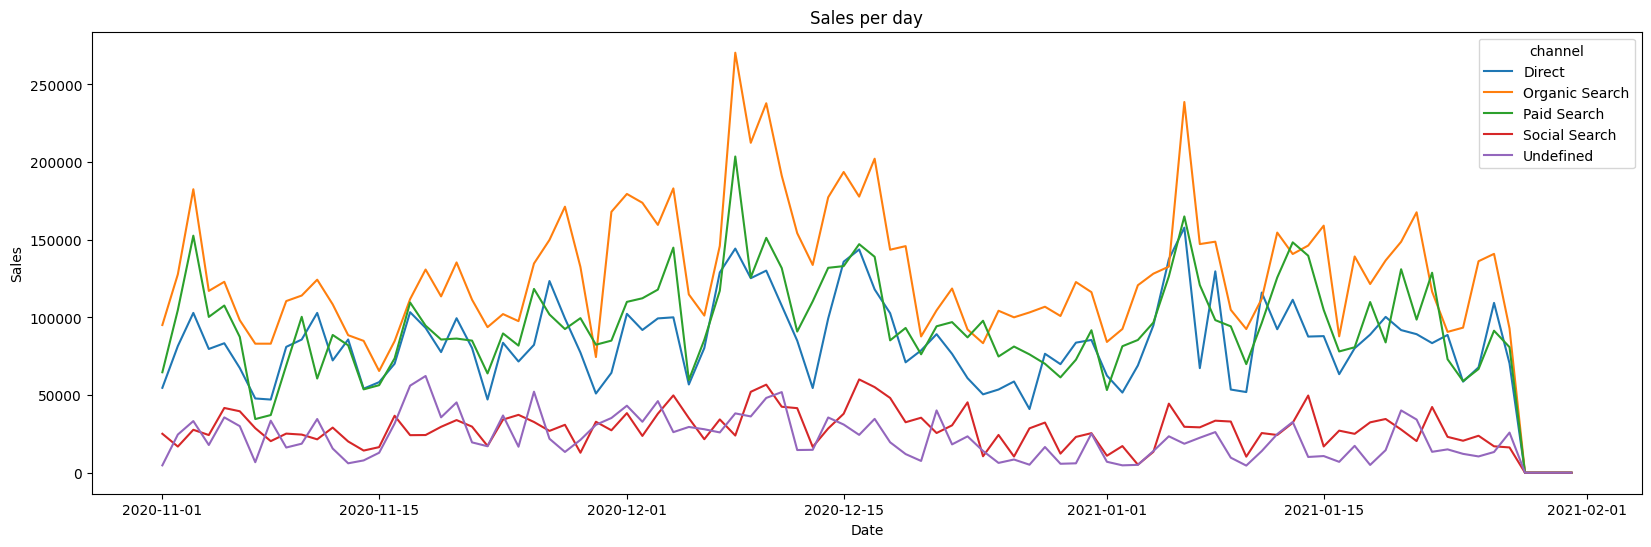

In [22]:
sales_per_channel = df.groupby(['order_date', 'channel'])['price'].sum().reset_index()

plt.figure(figsize=(20, 6))
sns.lineplot(data = sales_per_channel, x = 'order_date', y = 'price', hue = 'channel', ci=None)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales per day')
plt.show()


Organic Search is the most common

<ipython-input-23-91c9ed12584c>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data = sales_per_device, x = 'order_date', y = 'price', hue = 'device', ci=None)


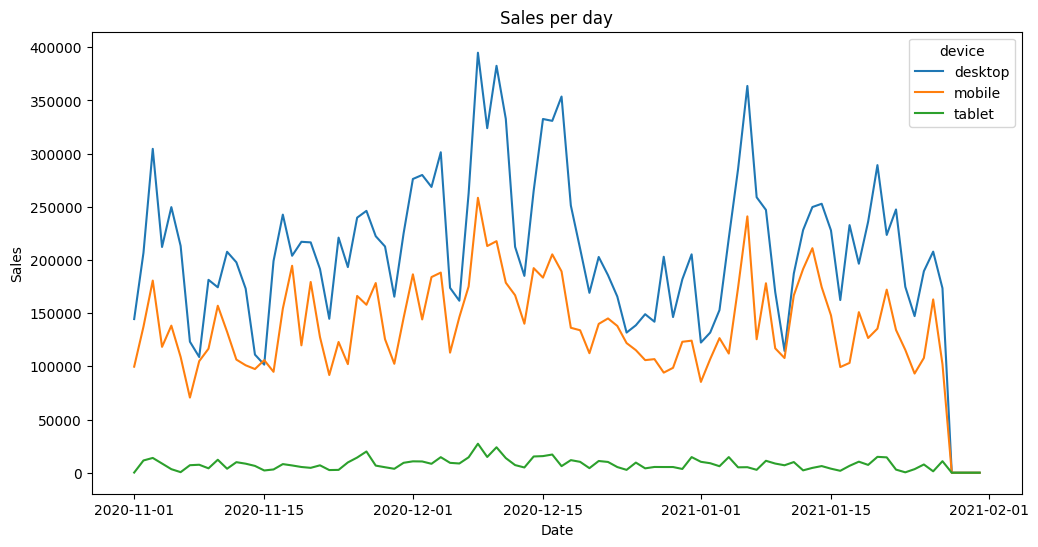

In [23]:
sales_per_device = df.groupby(['order_date', 'device'])['price'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data = sales_per_device, x = 'order_date', y = 'price', hue = 'device', ci=None)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales per day')
plt.show()

Mostly people tend to view the page through desktop

# **SUMMARY TABLES**

In [24]:
sessions_by_channel_device = df.groupby(['channel', 'device'])['ga_session_id'].count().reset_index()
sessions_by_channel_device = pd.DataFrame(sessions_by_channel_device)
sessions_by_channel_device.rename(columns={'ga_session_id': 'sessions'}, inplace=True)
sessions_by_channel_device

,channel,device,sessions
0,Direct,desktop,47825
1,Direct,mobile,31745
2,Direct,tablet,1812
3,Organic Search,desktop,72622
4,Organic Search,mobile,49014
5,Organic Search,tablet,2789
6,Paid Search,desktop,55167
7,Paid Search,mobile,37034
8,Paid Search,tablet,2140
9,Social Search,desktop,16288


In [25]:
sales_by_category = df.groupby(['country', 'category'])['price'].sum().reset_index()
sales_by_category = pd.DataFrame(sales_by_category)
sales_by_category.rename(columns={'price': 'sales'}, inplace=True)
sales_by_category = sales_by_category.sort_values(by='sales', ascending=False)
sales_by_category

,country,category,sales
1022,United States,Sofas & armchairs,3707144.5
1015,United States,Chairs,2619773.8
1011,United States,Beds,2213058.0
1012,United States,Bookcases & shelving units,1567606.9
1013,United States,Cabinets & cupboards,994545.5
...,...,...,...
575,Malta,Children's furniture,15.0
278,El Salvador,Bookcases & shelving units,15.0
694,Palestine,Children's furniture,15.0
145,Cambodia,Children's furniture,10.0


In [26]:
# order table
orders = df[df['category'].notnull()]
orders

# sales by category
sales_by_category = orders.groupby('category')['price'].sum().sort_values(ascending=False).head(10)
sales_by_category = pd.DataFrame(sales_by_category)
sales_by_category

,price
category,
Sofas & armchairs,8388254.5
Chairs,6147748.8
Beds,4919725.0
Bookcases & shelving units,3640818.1
Cabinets & cupboards,2336499.5
Outdoor furniture,2142222.2
Tables & desks,1790307.5
Chests of drawers & drawer units,906562.5
Bar furniture,735503.0


# **Statistical analysis of relationships**

In [27]:
sessions_sales_date = df.groupby('order_date')[['ga_session_id', 'price']].agg({'ga_session_id': 'count', 'price': 'sum'}).reset_index()
sessions_sales_date.rename(columns={'ga_session_id': 'sessions', 'price': 'sales'}, inplace=True)
sessions_sales_date

,order_date,sessions,sales
0,2020-11-01,2576,244292.5
1,2020-11-02,3599,355506.8
2,2020-11-03,5173,498979.6
3,2020-11-04,4184,339187.1
4,2020-11-05,3743,391276.6
...,...,...,...
87,2021-01-27,4435,286340.7
88,2021-01-28,4112,0.0
89,2021-01-29,3700,0.0
90,2021-01-30,2845,0.0


<ipython-input-28-77eed914c34c>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=sessions_sales_date, x='sessions', y='sales', palette="deep")


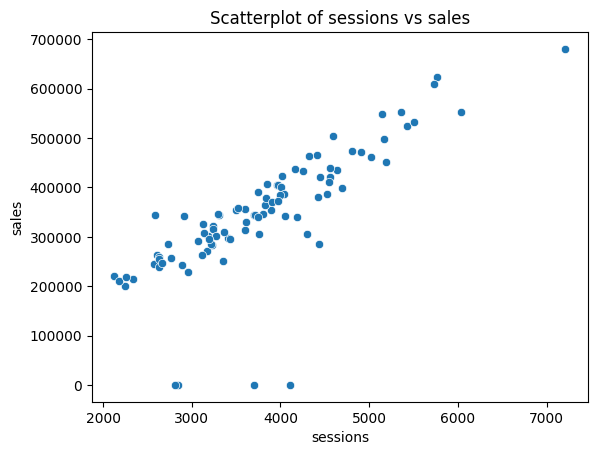

In [28]:
sns.scatterplot(data=sessions_sales_date, x='sessions', y='sales', palette="deep")
plt.title('Scatterplot of sessions vs sales')
plt.show()

In [29]:
correlation_sales_sessions, p_value = pearsonr(sessions_sales_date['sessions'], sessions_sales_date['sales'])

print(f'Correlation: {correlation_sales_sessions}')
print(f'P-value: {p_value}')

# Interpret the result
if p_value < 0.05:
    print("The correlation is statistically significant (p < 0.05).")
else:
    print("The correlation is not statistically significant (p >= 0.05).")

Correlation: 0.7910809164540888
P-value: 6.4835323120810494e-21
The correlation is statistically significant (p < 0.05).



There is a strong positive correlation between the number of sessions and the total sales. As the number of page views increases, sales tend to rise accordingly. This correlation is statistically significant

In [30]:
continents = df.groupby('continent')['price'].sum().sort_values(ascending=False).head(3)
main_cont = df[df['continent'].isin(['Americas', 'Asia', 'Europe'])]

sales_by_continent = main_cont.groupby(['order_date', 'continent'])['price'].sum().sort_values(ascending=False)
sales_by_continent = pd.DataFrame(sales_by_continent)
sales_by_continent.reset_index(inplace=True)
sales_by_continent

sales_by_continent_pivot = sales_by_continent.pivot(index='order_date', columns='continent', values='price').reset_index()

# Display the result
sales_by_continent_pivot


continent,order_date,Americas,Asia,Europe
0,2020-11-01,132002.5,63823.0,46908.0
1,2020-11-02,193861.0,79370.0,75710.8
2,2020-11-03,294529.8,126737.8,67692.0
3,2020-11-04,200009.5,66602.0,65915.0
4,2020-11-05,182988.2,117608.4,86540.0
...,...,...,...,...
87,2021-01-27,166735.5,66783.1,48156.1
88,2021-01-28,0.0,0.0,0.0
89,2021-01-29,0.0,0.0,0.0
90,2021-01-30,0.0,0.0,0.0


In [31]:
# Pairwise correlations and p-values
correlations = {}
p_values = {}

# Pairwise comparisons
for (x, y) in [('Americas', 'Asia'), ('Americas', 'Europe'), ('Asia', 'Europe')]:
    corr, p_val = pearsonr(sales_by_continent_pivot[x], sales_by_continent_pivot[y])
    correlations[f'{x} vs {y}'] = corr
    p_values[f'{x} vs {y}'] = p_val

# Print results
print("Pairwise Correlations:")
for pair, corr in correlations.items():
    print(f'{pair}: Correlation = {corr:.2f}, P-value = {p_values[pair]:.4f}')

# Interpretation
for pair, p_val in p_values.items():
    if p_val < 0.05:
        print(f'The correlation for {pair} is statistically significant (p < 0.05).')
    else:
        print(f'The correlation for {pair} is not statistically significant (p >= 0.05).')


Pairwise Correlations:
Americas vs Asia: Correlation = 0.79, P-value = 0.0000
Americas vs Europe: Correlation = 0.77, P-value = 0.0000
Asia vs Europe: Correlation = 0.77, P-value = 0.0000
The correlation for Americas vs Asia is statistically significant (p < 0.05).
The correlation for Americas vs Europe is statistically significant (p < 0.05).
The correlation for Asia vs Europe is statistically significant (p < 0.05).


Correlation Matrix:
continent  Americas      Asia    Europe
continent                              
Americas   1.000000  0.792025  0.770586
Asia       0.792025  1.000000  0.768427
Europe     0.770586  0.768427  1.000000


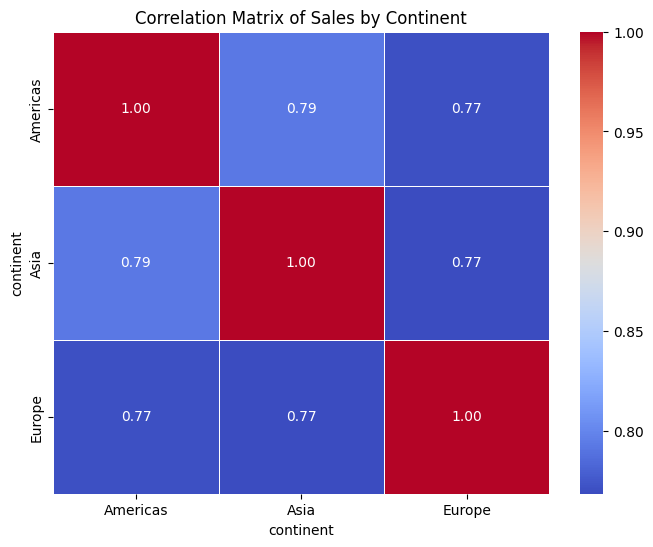

In [32]:
numeric_columns = sales_by_continent_pivot.drop(columns=['order_date'])
correlation_matrix = numeric_columns.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Sales by Continent')
plt.show()


The analysis shows strong and significant correlations between sales in each continent. However, correlation does not imply causation; a rise in sales in Europe does not necessarily cause an increase in sales in Asia or other continents. The observed relationship may be influenced by external factors or shared underlying trends rather than direct dependencies

In [34]:
sales_by_channel = df.groupby(['order_date', 'channel'])['price'].sum().sort_values(ascending=False)
sales_by_channel = pd.DataFrame(sales_by_channel)
sales_by_channel.reset_index(inplace=True)
sales_by_channel

sales_by_channel_pivot = sales_by_channel.pivot(index='order_date', columns='channel', values='price').reset_index()

sales_by_channel_pivot

channel,order_date,Direct,Organic Search,Paid Search,Social Search,Undefined
0,2020-11-01,54669.5,95112.0,64688.0,25078.0,4745.0
1,2020-11-02,81561.5,127746.5,104780.8,16843.0,24575.0
2,2020-11-03,102909.5,182521.9,152641.3,27652.5,33254.4
3,2020-11-04,79683.6,117067.1,100332.0,24257.4,17847.0
4,2020-11-05,83367.6,122938.4,107648.0,41693.2,35629.4
...,...,...,...,...,...,...
87,2021-01-27,70423.1,92921.1,80869.5,16282.0,25845.0
88,2021-01-28,0.0,0.0,0.0,0.0,0.0
89,2021-01-29,0.0,0.0,0.0,0.0,0.0
90,2021-01-30,0.0,0.0,0.0,0.0,0.0


Correlation Matrix:
channel           Direct  Organic Search  Paid Search  Social Search  \
channel                                                                
Direct          1.000000        0.837833     0.814072       0.604060   
Organic Search  0.837833        1.000000     0.870086       0.583117   
Paid Search     0.814072        0.870086     1.000000       0.596428   
Social Search   0.604060        0.583117     0.596428       1.000000   
Undefined       0.517505        0.526068     0.521961       0.455126   

channel         Undefined  
channel                    
Direct           0.517505  
Organic Search   0.526068  
Paid Search      0.521961  
Social Search    0.455126  
Undefined        1.000000  


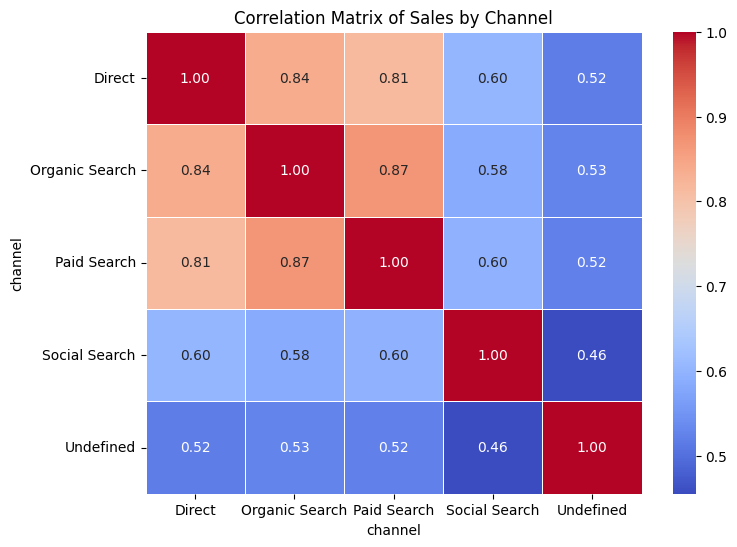

In [35]:
numeric_columns_channel = sales_by_channel_pivot.drop(columns=['order_date'])
correlation_matrix_channel = numeric_columns_channel.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix_channel)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_channel, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Sales by Channel')
plt.show()


In [36]:
# Initialize a DataFrame to store p-values
p_values = pd.DataFrame(np.zeros((numeric_columns_channel.shape[1], numeric_columns_channel.shape[1])), # set the size of the matrix,
                        columns=numeric_columns_channel.columns, index=numeric_columns_channel.columns) # set the column names and the row names

# Compute p-values for each pair of columns
for col1 in numeric_columns_channel.columns:
    for col2 in numeric_columns_channel.columns:
        if col1 != col2:
            corr, p_val = pearsonr(numeric_columns_channel[col1], numeric_columns_channel[col2])
            p_values.loc[col1, col2] = p_val
        else:
            p_values.loc[col1, col2] = np.nan  # Self-correlation is not relevant

p_values = pd.DataFrame(p_values)
p_values



channel,Direct,Organic Search,Paid Search,Social Search,Undefined
channel,,,,,
Direct,NaN,2.190420e-25,5.896435e-23,1.831889e-10,1.275436e-07
Organic Search,2.190420e-25,NaN,2.142003e-29,1.066192e-09,7.228214e-08
Paid Search,5.896435e-23,2.142003e-29,NaN,3.532284e-10,9.509609e-08
Social Search,1.831889e-10,1.066192e-09,3.532284e-10,NaN,5.161928e-06
Undefined,1.275436e-07,7.228214e-08,9.509609e-08,5.161928e-06,NaN


The highest correlation is between Organic and Paid Search and between Organic and DIrect search. The lowest is between Social and Organic Search (not taking in a count Undefined Search). All correlations values are significant

In [37]:
top_categories = df.groupby('category')['price'].sum().sort_values(ascending=False).head(5)
top_categories = pd.DataFrame(top_categories)
top_categories.reset_index(inplace=True)
print(top_categories)

# dataframe showing only top 5 categories sales
top_categories_sales = df[df['category'].isin(top_categories['category'])]


categories = top_categories_sales.groupby([ 'order_date', 'category'])['price'].sum().sort_values(ascending=False)
categories = pd.DataFrame(categories)
categories.rename(columns={'price': 'sales'}, inplace=True)
categories.reset_index(inplace=True)

categories_pivot = categories.pivot(index='order_date', columns='category', values='sales').reset_index()

# Display the result
categories_pivot

                     category      price
0           Sofas & armchairs  8388254.5
1                      Chairs  6147748.8
2                        Beds  4919725.0
3  Bookcases & shelving units  3640818.1
4        Cabinets & cupboards  2336499.5


category,order_date,Beds,Bookcases & shelving units,Cabinets & cupboards,Chairs,Sofas & armchairs
0,2020-11-01,14041.0,36701.0,13591.5,46006.0,75216.0
1,2020-11-02,79683.5,40979.0,21623.0,58834.0,79977.5
2,2020-11-03,66219.5,64360.1,33555.5,61204.0,175594.0
3,2020-11-04,48939.0,35719.8,19266.0,44113.0,86861.5
4,2020-11-05,23449.0,40998.8,29235.0,90388.4,137288.0
...,...,...,...,...,...,...
83,2021-01-23,37116.0,29862.7,26068.0,57493.0,76898.0
84,2021-01-24,23294.0,25396.0,23664.5,54288.0,57837.0
85,2021-01-25,47303.5,25919.6,33028.0,51424.2,84544.0
86,2021-01-26,69894.5,39119.2,20218.0,96216.2,85431.0


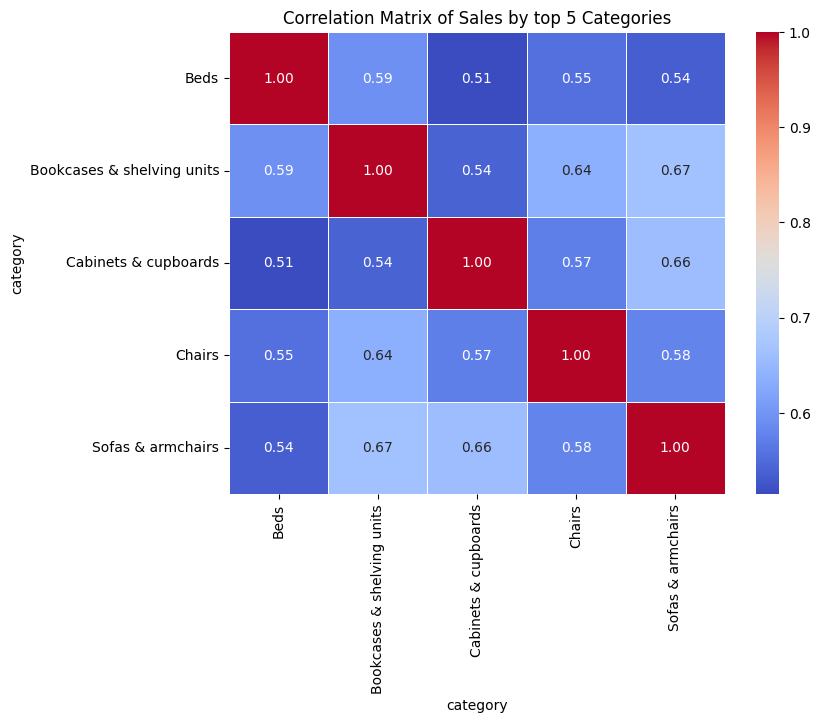

In [38]:
numeric_columns_category = categories_pivot.drop(columns=['order_date'])
correlation_matrix_category = numeric_columns_category.corr()

# print("Correlation Matrix:")
# print(correlation_matrix_category)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_category, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Sales by top 5 Categories')
plt.show()

In [39]:
p_values = pd.DataFrame(np.zeros((numeric_columns_category.shape[1], numeric_columns_category.shape[1])), # set the size of the matrix,
                        columns=numeric_columns_category.columns, index=numeric_columns_category.columns) # set the column names and the row names

# Compute p-values for each pair of columns
for col1 in numeric_columns_category.columns:
    for col2 in numeric_columns_category.columns:
        if col1 != col2:
            corr, p_val = pearsonr(numeric_columns_category[col1], numeric_columns_category[col2])
            p_values.loc[col1, col2] = p_val
        else:
            p_values.loc[col1, col2] = np.nan  # Self-correlation is not relevant

p_values = pd.DataFrame(p_values)
p_values

category,Beds,Bookcases & shelving units,Cabinets & cupboards,Chairs,Sofas & armchairs
category,,,,,
Beds,NaN,1.154998e-09,2.910930e-07,2.079183e-08,7.687333e-08
Bookcases & shelving units,1.154998e-09,NaN,5.867225e-08,2.504550e-11,1.406972e-12
Cabinets & cupboards,2.910930e-07,5.867225e-08,NaN,5.465903e-09,3.415056e-12
Chairs,2.079183e-08,2.504550e-11,5.465903e-09,NaN,3.638833e-09
Sofas & armchairs,7.687333e-08,1.406972e-12,3.415056e-12,3.638833e-09,NaN


It is a medium correlation betwen sales in top 5 categories. The highest correlation is between Bookcases & shelving units and Sofas & armchairs

# **Statistical analysis of differences between groups**

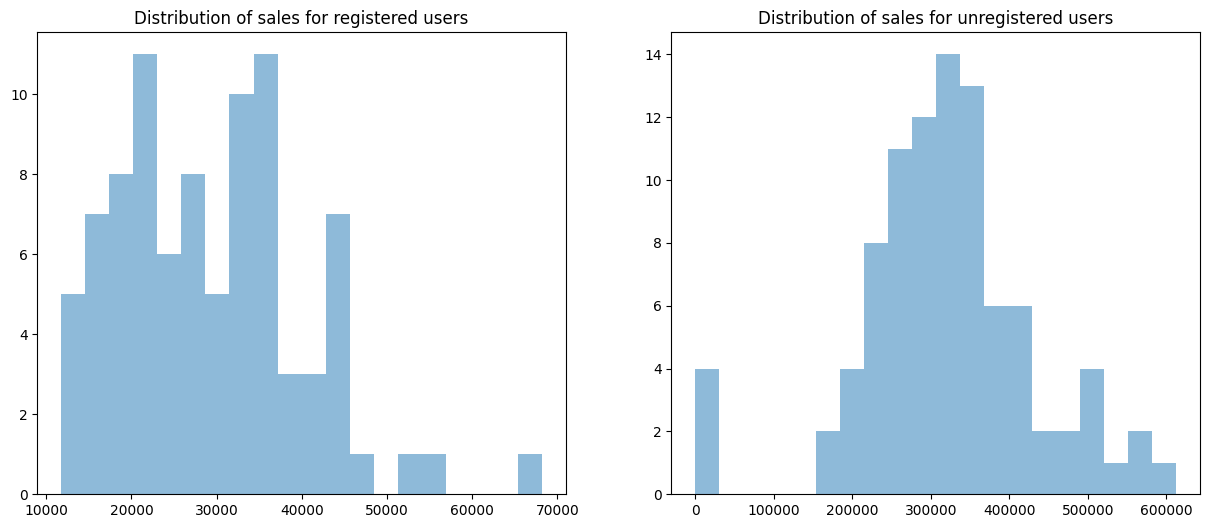

p-value of normality test for sales within subscribed users: 0.007295139880540744
p-value of normality test for sales within unsubscribed users: 0.0012184604855253293
Number of orders from subscribed users: 88
Number of orders from unsubscribed users: 92
Percent of orders from subscribed users: 0.31%
Percent of orders from unsubscribed users: 0.03%
Average sales for subscribed users: 29346.801136363636
Average sales for unsubscribed users: 319447.96304347826
p-value: 3.0766338232014304e-57


In [40]:
subscribed = df[df['account_id'].notnull()]
subscribed

subscribed_sales = subscribed.groupby('order_date')['price'].sum().reset_index()
subscribed_sales.rename(columns={'price': 'sales'}, inplace=True)
subscribed_sales

unsubscribed = df[df['account_id'].isnull()]
unsubscribed

unsubscribed_sales = unsubscribed.groupby('order_date')['price'].sum().reset_index()
unsubscribed_sales.rename(columns={'price': 'sales'}, inplace=True)
unsubscribed_sales

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].hist(subscribed_sales['sales'], bins=20, alpha=0.5, label='Subscribed')
ax[0].set_title('Distribution of sales for registered users')
ax[1].hist(unsubscribed_sales['sales'], bins=20, alpha=0.5, label='Unsubscribed')
ax[1].set_title('Distribution of sales for unregistered users')
plt.show()

# Normality test
_, p_value_norm_subscribed = shapiro(subscribed_sales['sales'])
_, p_value_norm_unsubscribed = shapiro(unsubscribed_sales['sales'])
print(f"p-value of normality test for sales within subscribed users: {p_value_norm_subscribed}")
print(f"p-value of normality test for sales within unsubscribed users: {p_value_norm_unsubscribed}")


subscribed_sales_cnt = subscribed_sales['sales'].count()
unsubscribed_sales_cnt = unsubscribed_sales['sales'].count()
print(f'Number of orders from subscribed users: {subscribed_sales_cnt}')
print(f'Number of orders from unsubscribed users: {unsubscribed_sales_cnt}')

subscribed_sales_percent = subscribed_sales_cnt / subscribed.shape[0] * 100
unsubscribed_sales_percent = unsubscribed_sales_cnt / unsubscribed.shape[0] * 100
print(f'Percent of orders from subscribed users: {subscribed_sales_percent:.2f}%')
print(f'Percent of orders from unsubscribed users: {unsubscribed_sales_percent:.2f}%')


avg_subscribed_sales = subscribed_sales['sales'].mean()
avg_unsubscribed_sales = unsubscribed_sales['sales'].mean()
print(f'Average sales for subscribed users: {avg_subscribed_sales}')
print(f'Average sales for unsubscribed users: {avg_unsubscribed_sales}')


t_stat, p_value = stats.ttest_ind(subscribed_sales['sales'], unsubscribed_sales['sales'])

# Print the p-value
print(f"p-value: {p_value}")

- p-value of normality < 0.05 ---> means our sales distribution is not normal
- it can be seen, that company gets more orders from unsubscribed users, but in pervcentage terms only 0,03 percent of unsubscribed users make an order, compared to subscribed 0,31%
- Average sales for unsubscribed users is higher, but as was mentioned before, that only because the company has much more unsubscribed users and in the percentage terms, there are better sales for the subscribed users
- Difference between sales of subscribed and unsubscribed users is significant


In [42]:
df['channel'].unique()
direct_cnt = df[df['channel'] == 'Direct']['ga_session_id'].count()
organic_cnt = df[df['channel'] == 'Organic Search']['ga_session_id'].count()
paid_cnt = df[df['channel'] == 'Paid Search']['ga_session_id'].count()
social_cnt = df[df['channel'] == 'Social Search']['ga_session_id'].count()

print(f'Number of sessions from Direct channel: {direct_cnt}')
print(f'Number of sessions from Organic Search channel: {organic_cnt}')
print(f'Number of sessions from Paid Search channel: {paid_cnt}')
print(f'Number of sessions from Social channel: {social_cnt}')


print('')
print('Null Hypothesis (H₀): There is no significant difference between the mean number of sessions for the channels.')
print('Alternative Hypothesis (H₁): At least one channels mean number of sessions is significantly different from the others')
print('')

# Extract session counts for each channel
direct_sessions = df[df['channel'] == 'Direct']['ga_session_id']
organic_sessions = df[df['channel'] == 'Organic Search']['ga_session_id']
paid_sessions = df[df['channel'] == 'Paid Search']['ga_session_id']
social_sessions = df[df['channel'] == 'Social Search']['ga_session_id']

# Perform one-way ANOVA
f_stat, p_value = f_oneway(direct_sessions, organic_sessions, paid_sessions, social_sessions)

print(f'ANOVA F-statistic: {f_stat}, p-value: {p_value}')
print('')

if (p_value < 0.05):
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis - there is no significant difference between the sales between groups')


Number of sessions from Direct channel: 81382
Number of sessions from Organic Search channel: 124425
Number of sessions from Paid Search channel: 94341
Number of sessions from Social channel: 27914

Null Hypothesis (H₀): There is no significant difference between the mean number of sessions for the channels.
Alternative Hypothesis (H₁): At least one channels mean number of sessions is significantly different from the others

ANOVA F-statistic: 1.5615574532867815, p-value: 0.19639985291421536

Fail to reject the null hypothesis - there is no significant difference between the sales between groups


In [43]:
number_of_days = df['order_date'].nunique()
print(f'Number of days: {number_of_days}')

Number of days: 92


# **TABLEAU DASHBOARD**
[Tableau Dashboard](https://public.tableau.com/app/profile/kateryna.nevmerzhytska/viz/CustomerOrderAnalysis_17321052170450/Dashboard1?publish=yes)